In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

import torch
import fastai.text as fnlp

In [2]:
## path
path = fnlp.untar_data(fnlp.URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/root/.fastai/data/imdb/models')]

In [5]:
!ls '/root/.fastai/data/imdb/train/neg'

0_3.txt      11877_1.txt  2501_1.txt  4378_4.txt  6253_2.txt  8129_3.txt
10000_4.txt  11878_1.txt  2502_1.txt  4379_1.txt  6254_3.txt  812_3.txt
10001_4.txt  11879_1.txt  2503_1.txt  437_4.txt   6255_1.txt  8130_3.txt
10002_1.txt  1187_3.txt   2504_3.txt  4380_1.txt  6256_3.txt  8131_1.txt
10003_1.txt  11880_1.txt  2505_2.txt  4381_2.txt  6257_1.txt  8132_3.txt
10004_3.txt  11881_1.txt  2506_3.txt  4382_3.txt  6258_4.txt  8133_1.txt
10005_3.txt  11882_1.txt  2507_2.txt  4383_1.txt  6259_3.txt  8134_3.txt
10006_4.txt  11883_1.txt  2508_4.txt  4384_1.txt  625_4.txt   8135_2.txt
10007_1.txt  11884_4.txt  2509_4.txt  4385_3.txt  6260_1.txt  8136_1.txt
10008_2.txt  11885_1.txt  250_3.txt   4386_3.txt  6261_2.txt  8137_4.txt
10009_1.txt  11886_1.txt  2510_4.txt  4387_3.txt  6262_1.txt  8138_2.txt
1000_4.txt   11887_1.txt  2511_4.txt  4388_2.txt  6263_1.txt  8139_1.txt
10010_3.txt  11888_2.txt  2512_4.txt  4389_2.txt  6264_2.txt  813_3.txt
10011_3.txt  11889_1.txt  2513_4.txt  438_4.txt   626

### data_bunch_lm

In [3]:
data_lm = (fnlp.TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
            .split_by_rand_pct(0.1)
            .label_for_lm()
            .databunch(bs=128))

data_lm.save('data_lm.pkl')

In [ ]:
# data_lm = fnlp.load_data(path, 'data_lm.pkl', bs = 128)

In [4]:
learn = fnlp.language_model_learner(data_lm, fnlp.AWD_LSTM, drop_mult=0.3).to_fp16()

# Language modeling
### lr_find

In [5]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


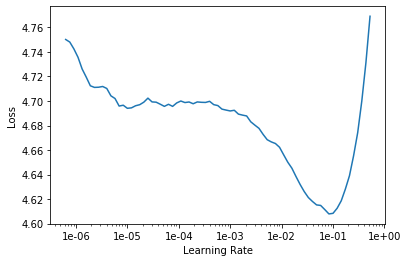

In [6]:
learn.recorder.plot(skip_end=15)

In [7]:
learn.unfreeze()
learn.fit_one_cycle(20, 0.005, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.929454,3.836644,0.317789,07:13
1,3.799075,3.732668,0.325953,07:15
2,3.771101,3.714767,0.326593,07:17
3,3.769655,3.726828,0.324866,07:18
4,3.772523,3.736697,0.324130,07:13
5,3.767695,3.735204,0.323707,07:12
6,3.729446,3.716692,0.325682,07:13
7,3.711613,3.697795,0.327675,07:14
8,3.655825,3.679902,0.329572,07:15
9,3.633856,3.654978,0.332348,07:15


In [9]:
learn.save('fine_tuned_lm')

In [10]:
learn.save_encoder('fine_tuned_encoder')

---

# Classifier

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch
import fastai.text as fnlp

In [3]:
path = fnlp.untar_data(fnlp.URLs.IMDB)

In [4]:
data_lm_vocab = fnlp.load_data(path, 'data_lm.pkl', bs = 128).vocab

In [5]:
data_clas = (fnlp.TextList.from_folder(path, vocab = data_lm_vocab)
             .split_by_folder(valid='test')
             .label_from_folder(classes=['neg', 'pos'])
             .databunch(bs=32))

data_clas.save('data_clas.pkl')

In [6]:
data_clas = fnlp.load_data(path, 'data_clas.pkl', bs=32)

In [7]:
learn = fnlp.text_classifier_learner(data_clas, fnlp.AWD_LSTM, drop_mult=0.5)

In [6]:
learn.load_encoder('fine_tuned_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 
 
  xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 
 
  xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker )

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


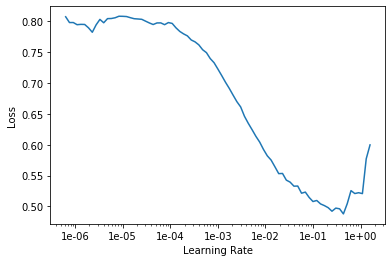

In [8]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.262868,0.170249,0.936760,02:38


In [11]:
learn.save('AWD_LSTM-fine_tuning_lm-fine_tuning_cls_1')

In [8]:
learn.load('AWD_LSTM-fine_tuning_lm-fine_tuning_cls_1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 
 
  xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 
 
  xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker )

In [9]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.248474,0.152553,0.944480,02:52


In [10]:
learn.save('AWD_LSTM-fine_tuning_lm-fine_tuning_cls_2')

In [11]:
learn.load('AWD_LSTM-fine_tuning_lm-fine_tuning_cls_2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 
 
  xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 
 
  xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker )

In [12]:
learn.freeze_to(-3)

In [14]:
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.225399,0.150792,0.943800,03:42


In [15]:
learn.save('AWD_LSTM-fine_tuning_lm-fine_tuning_cls_3')

In [16]:
learn.load('AWD_LSTM-fine_tuning_lm-fine_tuning_cls_3')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 
 
  xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 
 
  xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker )

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.184415,0.147003,0.946800,04:35
1,0.186583,0.146394,0.946400,04:51
